In [1]:
import torch
import torchvision
from torchvision import models, transforms
from torch.optim import lr_scheduler
import torch.optim as optim
from tempfile import TemporaryDirectory
import time
import os

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

epochs = 5

trainset_Eurosat = torchvision.datasets.EuroSAT(root='./data',
                                        download=True, transform=transform) #kein train test split
generator = torch.Generator().manual_seed(42)
eurosat_train, eurosat_test = torch.utils.data.random_split(trainset_Eurosat, [0.7, 0.3], generator)
trainloader = torch.utils.data.DataLoader(eurosat_train, batch_size=4,
                                           shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(eurosat_test, batch_size=4,
                                           shuffle=True, num_workers=2)
classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
           'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

dataset_sizes = {"train":len(trainloader)*batch_size, "val":len(testloader)*batch_size}

print(dataset_sizes)

{'train': 18900, 'val': 8100}


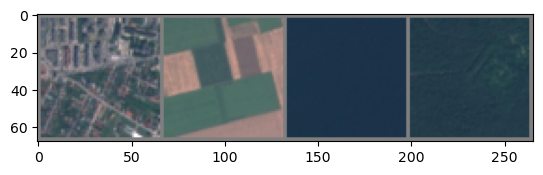

Residential AnnualCrop SeaLake Forest


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 13 * 13, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [6]:
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
def train(epoch):
    
    for epoch in range(epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                
                running_loss = 0.0

    print('Finished Training')

In [8]:
def test():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [9]:
train(epochs)
test()

[1,  2000] loss: 1.664
[1,  4000] loss: 1.265
[2,  2000] loss: 1.015
[2,  4000] loss: 0.956
[3,  2000] loss: 0.795
[3,  4000] loss: 0.774
[4,  2000] loss: 0.647
[4,  4000] loss: 0.625
[5,  2000] loss: 0.513
[5,  4000] loss: 0.518
Finished Training
Accuracy of the network on the test images: 74 %


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                loaders = {"train":trainloader, "val":testloader}
                for inputs, labels in loaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

ConvNet as fixed feature extractor

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=epochs)

Epoch 0/4
----------
train Loss: 1.5216 Acc: 0.5467
val Loss: 2.0308 Acc: 0.6233

Epoch 1/4
----------
train Loss: 1.4544 Acc: 0.5920
val Loss: 1.6365 Acc: 0.6306

Epoch 2/4
----------
train Loss: 1.4731 Acc: 0.5892
val Loss: 1.5678 Acc: 0.6535

Epoch 3/4
----------
train Loss: 1.4811 Acc: 0.5907
val Loss: 1.5900 Acc: 0.6093

Epoch 4/4
----------
train Loss: 1.5061 Acc: 0.5888
val Loss: 1.2891 Acc: 0.6762

Training complete in 5m 42s
Best val Acc: 0.676173


Finetuning

In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/4
----------
train Loss: 0.9826 Acc: 0.7014
val Loss: 0.3968 Acc: 0.8774

Epoch 1/4
----------
train Loss: 0.4953 Acc: 0.8461
val Loss: 0.2748 Acc: 0.9168

Epoch 2/4
----------
train Loss: 0.3700 Acc: 0.8826
val Loss: 0.3348 Acc: 0.8983

Epoch 3/4
----------
train Loss: 0.2866 Acc: 0.9075
val Loss: 0.4200 Acc: 0.8568

Epoch 4/4
----------
train Loss: 0.2387 Acc: 0.9231
val Loss: 0.2071 Acc: 0.9358

Training complete in 13m 17s
Best val Acc: 0.935802


ConvNet as fixed feature extractor

In [15]:
model_conv = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=epochs)

Epoch 0/4
----------
train Loss: 1.5965 Acc: 0.4475
val Loss: 1.8957 Acc: 0.3464

Epoch 1/4
----------
train Loss: 1.5242 Acc: 0.4789
val Loss: 1.8839 Acc: 0.3373

Epoch 2/4
----------
train Loss: 1.5127 Acc: 0.4841
val Loss: 1.9036 Acc: 0.3316

Epoch 3/4
----------
train Loss: 1.5176 Acc: 0.4803
val Loss: 1.8707 Acc: 0.3346

Epoch 4/4
----------
train Loss: 1.5173 Acc: 0.4828
val Loss: 1.9089 Acc: 0.3165

Training complete in 56m 2s
Best val Acc: 0.346420


Finetuning

In [17]:
model_ft = models.efficientnet_b5(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[-1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.classifier[-1] = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/4
----------
train Loss: 0.8682 Acc: 0.7093
val Loss: 0.4780 Acc: 0.8695

Epoch 1/4
----------
train Loss: 0.3857 Acc: 0.8762
val Loss: 0.2806 Acc: 0.9242

Epoch 2/4
----------
train Loss: 0.2567 Acc: 0.9175
val Loss: 0.2605 Acc: 0.9212

Epoch 3/4
----------
train Loss: 0.1898 Acc: 0.9392
val Loss: 0.2270 Acc: 0.9328

Epoch 4/4
----------
train Loss: 0.1437 Acc: 0.9542
val Loss: 0.2117 Acc: 0.9311

Training complete in 73m 46s
Best val Acc: 0.932840
